### Business Context

Labels of the dataset:
* `information` objective statements about the company or it's activities, 

* `dialog` Replies to users, etc.

* `action` (messages that ask for votes or ask users to click on links, etc.). ,

Aim is to build a model to automatically categorize the text into their respective categories. 

[Dataset can be found from here.](https://data.world/crowdflower/corporate-messaging)

### Import libraries

In [2]:
# load required libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stopword = stopwords.words('english')

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
non_ascii_regex = r'[^\x00-\x7F]+'

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# load data
path = "/content/corporate_messaging_dfe.csv"
data = pd.read_csv(path)

In [4]:
# check tail and head
data.head(-4)

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,category,category_confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2015-02-18T04:31:00,Information,1.0000,NaN,436528000000000000,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2015-02-18T13:55:00,Information,1.0000,NaN,386013000000000000,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2015-02-18T08:43:00,Information,1.0000,NaN,379580000000000000,Barclays,Barclays publishes its prospectus for its �5.8...
3,662822311,False,finalized,3,2015-02-18T09:13:00,Information,1.0000,NaN,367530000000000000,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2015-02-18T06:48:00,Information,1.0000,NaN,360385000000000000,Barclays,Barclays announces that Irene McDermott Brown ...
...,...,...,...,...,...,...,...,...,...,...,...
3109,677278309,True,golden,6,NaN,Information,1.0000,Information,394872000000000000,Nestle,We̢���re working hard to do all we can to pro...
3110,677278310,True,golden,8,NaN,Action,0.7555,Action,392785000000000000,Citi,Wish children ate healthier? See how Trees for...
3111,677278311,True,golden,6,NaN,Action,0.8390,Action,388027000000000000,Citi,Wish cities were more child-friendly? See how ...
3112,677278312,True,golden,9,NaN,Dialogue,0.8889,Dialogue,418780000000000000,Merck,Wishing all of our followers a happy and healt...


In [5]:
# general info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unit_id              3118 non-null   int64  
 1   golden               3118 non-null   bool   
 2   unit_state           3118 non-null   object 
 3   trusted_judgments    3118 non-null   int64  
 4   last_judgment_at     2811 non-null   object 
 5   category             3118 non-null   object 
 6   category_confidence  3118 non-null   float64
 7   category_gold        307 non-null    object 
 8   id                   3118 non-null   int64  
 9   screenname           3118 non-null   object 
 10  text                 3118 non-null   object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 246.8+ KB


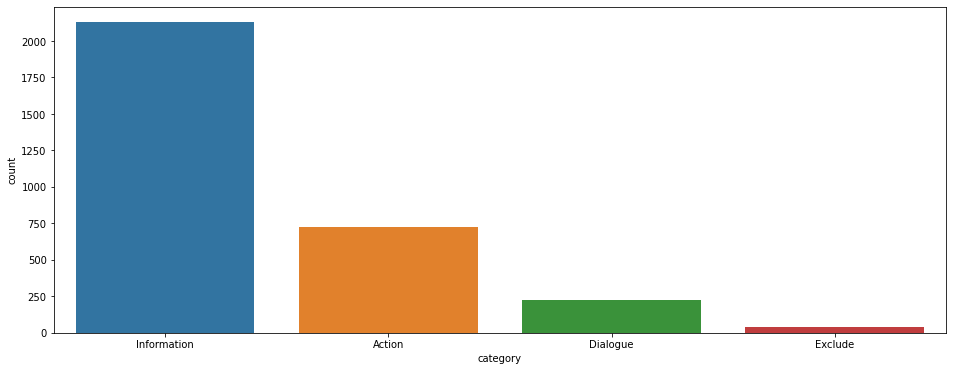

In [6]:
# check distribution of target column
plt.figure(figsize = (16,6))
sns.countplot(data = data, x = 'category')
plt.show()

In [7]:
# check distribution of the column - category_confidence
data['category_confidence'].value_counts()

1.0000    2430
0.6614      35
0.6643      33
0.6747      32
0.6775      29
          ... 
0.8547       1
0.6641       1
0.8578       1
0.9089       1
0.8245       1
Name: category_confidence, Length: 194, dtype: int64

In [8]:
# remove those observations where category_confidence < 1 and category = Exclude
data = data[np.logical_and((data['category_confidence'] == 1), (data['category'] != 'Exclude'))]
data['category_confidence'].value_counts()

1.0    2403
Name: category_confidence, dtype: int64

In [9]:
# prep features and labels
features = data['text']
labels = data['category']

### Text preprocessing

- **Tokenizing** the sentences
- **Replace** the urls with a placeholder
- **Removing** non ascii characters
- **Text** normalizing using lemmatization

In [10]:
def tokenize(text):
    
    text = re.sub(url_regex, 'urlplaceholder', text)
    text = re.sub(non_ascii_regex, ' ', text)  

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    # lemmatize the tokens and remove the the stopwords
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]

    return clean_tokens

### Exploratory Data Analysis

**Hypothesis 1:** The length of the text in each category might be different from each other
<br>**Hypothesis 2:** The total number of URLs that are present in text might be different in each category

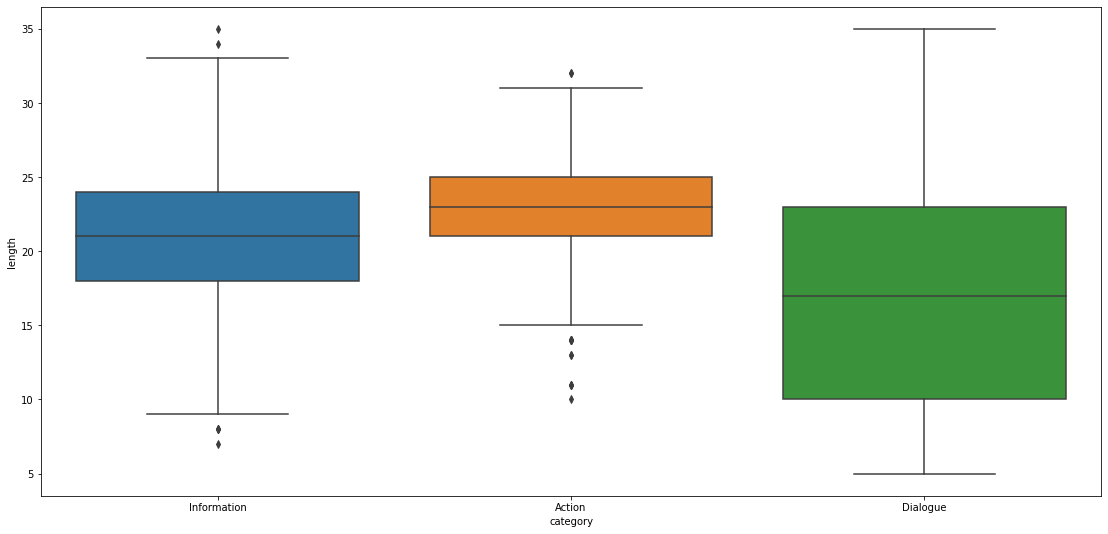

In [11]:
# length of each text
data['length'] = data['text'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize = (19,9))
sns.boxplot(data = data, x = 'category', y = 'length')
plt.show()

In [12]:
# count of urls present in each text
data['url_count'] = data.text.apply(lambda x: len(re.findall(url_regex, x)))

pd.crosstab(data.category, data['url_count'])

url_count,0,1,2
category,,,
Action,35,399,22
Dialogue,79,45,0
Information,494,1283,46


### Create Custom Transformers

An estimator is any object that learns from data, whether it's a classification, regression, or clustering algorithm, or a transformer that extracts or filters useful features from raw data. Since estimators learn from data, they each must have a `fit` method that takes a dataset.

There are two kinds of estimators - `Transformer Estimators` i.e. transformers in short and `Predictor Estimators` i.e. predictor in short. In transformers we also need to have another method `transform` and predictors need to have another method `predict`.

Some examples of `transformers` are - CountVectorizer, TfidfVectorizer, MinMaxScaler, StandardScaler etc.

Some examples of `predictors` are - LinearRegression, LogisticRegression, RandomForestClassifier etc.

In [13]:
class LengthExtractor(BaseEstimator, TransformerMixin):
  
  def compute_length(self,text):
    return len(word_tokenize(text))

  def fit(self, x, y = None): # transformer does not need y
    return self  

  def transform(self, x):
    x_len = pd.Series(x).apply(self.compute_length)
    return pd.DataFrame(x_len)


class url_counter(BaseEstimator, TransformerMixin):

  def total_url(self, text):
    return len(re.findall(url_regex, text))

  def fit(self, x, y = None):
    return self

  def transform(self, x):
    x_len = pd.Series(x).apply(self.total_url)
    return pd.DataFrame(x_len)    

### Model Building using FeatureUnion

Feature union applies a list of transformer objects in parallel to the input data, then concatenates the results. This is useful to combine several feature extraction mechanisms into a single transformer.

In [14]:
# split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, train_size = 0.8)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (1922,)
X_test shape: (481,)
Y_train shape: (1922,)
Y_test shape: (481,)


In [15]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train),
                                                 Y_train)
class_weight_dict = {'Action': class_weights[0],
                   'Dialogue': class_weights[1],
                   'Information': class_weights[2]}
class_weight_dict                   

{'Action': 1.7409420289855073,
 'Dialogue': 6.743859649122807,
 'Information': 0.4391135480923007}

In [37]:
# create an instance of Pipeline class
pipeline = Pipeline([
                     ('features', FeatureUnion([
                                                ('text_pipeline',Pipeline([
                                                                           ('vect', CountVectorizer(tokenizer = tokenize)),
                                                                           ('tfidf', TfidfTransformer())
                                                ])),
                     ('text_len', LengthExtractor()),

                     ('url_count', url_counter())
                     ])),

                     ('clf', RandomForestClassifier(n_estimators=350, class_weight=class_weight_dict,
                                                    max_depth = 12, max_features = 'log2',
                                                    criterion = 'entropy'))
])

In [38]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

### Model Predictions & Evaluation

In [39]:
# get predictions
y_hat = pipeline.predict(X_test)
y_hat_train = pipeline.predict(X_train)

In [40]:
print(classification_report(Y_train, y_hat_train))

              precision    recall  f1-score   support

      Action       0.99      0.95      0.97       368
    Dialogue       0.96      1.00      0.98        95
 Information       0.99      1.00      0.99      1459

    accuracy                           0.99      1922
   macro avg       0.98      0.98      0.98      1922
weighted avg       0.99      0.99      0.99      1922



In [41]:
print(classification_report(Y_test, y_hat))

              precision    recall  f1-score   support

      Action       0.90      0.75      0.82        88
    Dialogue       0.96      0.90      0.93        29
 Information       0.94      0.98      0.96       364

    accuracy                           0.93       481
   macro avg       0.93      0.88      0.90       481
weighted avg       0.93      0.93      0.93       481



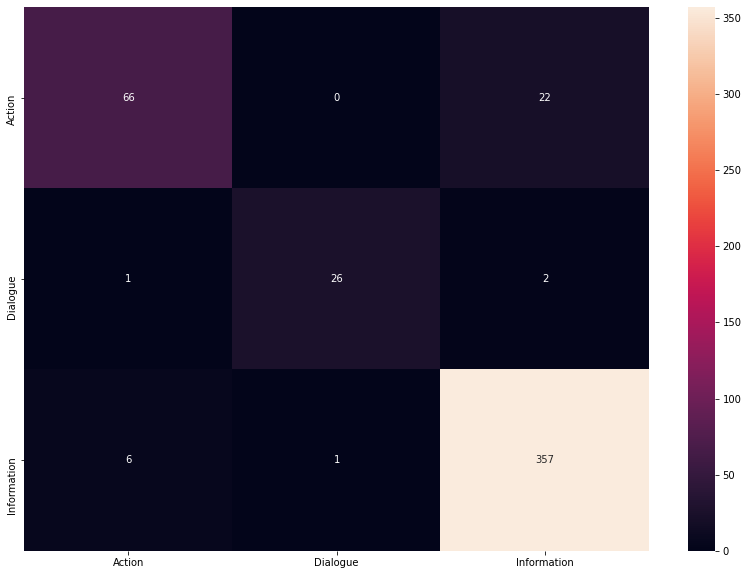

In [42]:
cm = confusion_matrix(Y_test, y_hat)

index = ['Action','Dialogue','Information']
columns = ['Action','Dialogue','Information']

cm_df = pd.DataFrame(cm,columns,index)                      

plt.figure(figsize=(14,10))  
sns.heatmap(cm_df, annot=True, fmt = 'd')
plt.show()